In [1]:
import tensorrt
print(tensorrt.__version__)

8.6.1


In [2]:
import tensorflow as tf
import keras_tuner as kt

2023-06-07 22:02:45.757250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
tf.get_logger().setLevel('ERROR')

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255, x_test / 255
x_train.shape

(60000, 28, 28)

In [6]:
import pandas as pd

In [7]:
from matplotlib import pyplot as plt

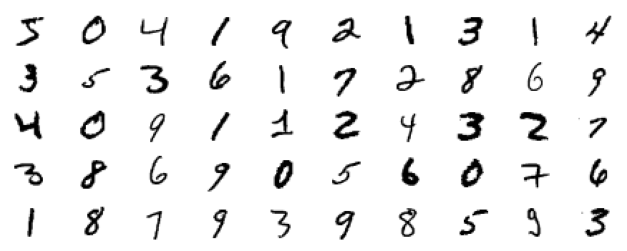

In [8]:
fig, axes = plt.subplots(5, 10, figsize=(8, 3), squeeze=False)
for y in range(5):
    for x in range(10):
        ax: plt.Axes = axes[y][x]
        index = y * 10 + x
        ax.imshow(x_train[index], cmap='binary')
        ax.set_axis_off()
display()

In [11]:
display(x_train[0])

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

# Auto tuning

In [12]:
class MnistHyperModel(kt.HyperModel):
    def build(self, hp: kt.HyperParameters):
        hidden_layers = hp.Int('hidden_layers', min_value=2, max_value=8, default=2)
        neurons = hp.Int('neurons', min_value=10, max_value=300, default=100)
        activation = hp.Choice('activation', ['relu', 'tanh'], default='relu')
        learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log', default=1e-5)
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
        for _ in range(hidden_layers):
            model.add(tf.keras.layers.Dense(neurons, activation=activation))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics=[tf.keras.metrics.sparse_categorical_accuracy]
        )
        return model

    def fit(self, hp: kt.HyperParameters, model: tf.keras.Model, *args, **kwargs):
        return model.fit(*args, batch_size=hp.Int('batch_size', min_value=32, max_value=128), **kwargs)

In [13]:
search = kt.Hyperband(
    MnistHyperModel(),
    objective='val_sparse_categorical_accuracy',
    max_epochs=20,
    factor=3,
    hyperband_iterations=2,
    seed=42,
    # overwrite=True,
    directory='mnist_model',
    project_name='hyperband'
)

In [14]:
import os

In [15]:
tensorboard_dir = os.path.join(search.project_dir, 'tensorboard')
tensorboard_cb = tf.keras.callbacks.TensorBoard(tensorboard_dir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
print(f'run\ntensorboard --logdir=ch10/{tensorboard_dir}')

run
tensorboard --logdir=ch10/mnist_model/hyperband/tensorboard


In [16]:
search.search(
    x_train,
    y_train,
    callbacks=[tensorboard_cb, early_stopping_cb],
    validation_split=0.1
)

In [27]:
best_trial: kt.engine.trial.Trial = search.oracle.get_best_trials(1)[0]
best_trial

In [28]:
best_model: tf.keras.Model = search.get_best_models(1)[0]
best_hp: kt.HyperParameters = search.get_best_hyperparameters(1)[0]

2023-06-06 22:12:36.561360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 22:12:36.614765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 22:12:36.614804: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 22:12:36.616459: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 22:12:36.616493: I tensorflow/compile

{'hidden_layers': 8,
 'neurons': 289,
 'activation': 'relu',
 'learning_rate': 0.0002491419010534623,
 'batch_size': 104,
 'tuner/epochs': 7,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [31]:
folder = 'mnist_model/final_model'
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(folder)
tensorboard_cb = tf.keras.callbacks.TensorBoard(folder)
hist = best_model.fit(
    x_train,
    y_train,
    epochs=100,
    callbacks=[early_stopping_cb, checkpoint_cb, tensorboard_cb],
    validation_split=0.1
)

Epoch 1/100


2023-06-06 22:20:42.158497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-06 22:20:42.166845: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x3659d6d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-06 22:20:42.166878: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-06-06 22:20:42.173001: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-06-06 22:20:45.653771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-06-06 22:20:45.759213: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-06 22:20:4

1688/1688 [==============================] - 20s 8ms/step - loss: 0.0901 - sparse_categorical_accuracy: 0.9729 - val_loss: 0.0788 - val_sparse_categorical_accuracy: 0.9785
Epoch 2/100
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0561 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.0871 - val_sparse_categorical_accuracy: 0.9763
Epoch 3/100
1688/1688 [==============================] - 13s 7ms/step - loss: 0.0494 - sparse_categorical_accuracy: 0.9855 - val_loss: 0.1024 - val_sparse_categorical_accuracy: 0.9740
Epoch 4/100
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0406 - sparse_categorical_accuracy: 0.9879 - val_loss: 0.0957 - val_sparse_categorical_accuracy: 0.9740
Epoch 5/100
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0352 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.0862 - val_sparse_categorical_accuracy: 0.9788
Epoch 6/100
1688/1688 [==============================] - 13s 7ms/step - loss: 0.0296 - spars

<Axes: >

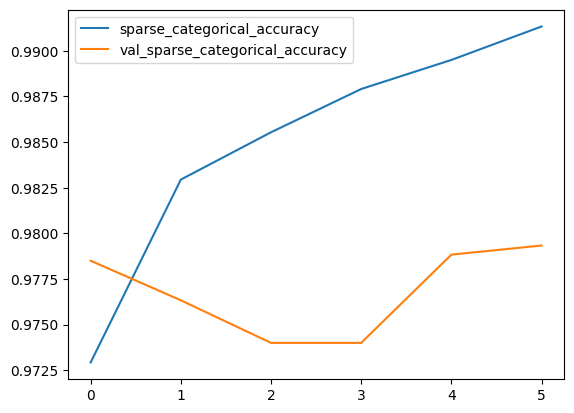

In [37]:
pd.DataFrame(hist.history)[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [38]:
best_model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.0978 - sparse_categorical_accuracy: 0.9727


[0.09778677672147751, 0.9726999998092651]

In [41]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 289)               226865    
                                                                 
 dense_1 (Dense)             (None, 289)               83810     
                                                                 
 dense_2 (Dense)             (None, 289)               83810     
                                                                 
 dense_3 (Dense)             (None, 289)               83810     
                                                                 
 dense_4 (Dense)             (None, 289)               83810     
                                                                 
 dense_5 (Dense)             (None, 289)               8

# Manual tuning

In [43]:
import numpy as np

In [48]:
def build_model(learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(28 * 28 / 2, activation='relu'),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss=tf.losses.sparse_categorical_crossentropy,
        optimizer=optimizer,
        metrics=[tf.metrics.sparse_categorical_accuracy]
    )
    return model

In [62]:
learning_rates = np.linspace(1e-5, 0.04, 10)

In [63]:
losses = []
for lr in learning_rates:
    print(f'LEARNING RATE: {lr}')
    model = build_model(lr)
    hist: tf.keras.callbacks.History = model.fit(
        x_train,
        y_train,
        epochs=2,
        validation_split=0.1
    )
    losses.append(hist.history['val_loss'])

LEARNING RATE: 1e-05
Epoch 1/2
1688/1688 [==============================] - 8s 4ms/step - loss: 1.3360 - sparse_categorical_accuracy: 0.6907 - val_loss: 0.6027 - val_sparse_categorical_accuracy: 0.8878
Epoch 2/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.5114 - sparse_categorical_accuracy: 0.8789 - val_loss: 0.3514 - val_sparse_categorical_accuracy: 0.9167
LEARNING RATE: 0.004453333333333333
Epoch 1/2
1688/1688 [==============================] - 8s 4ms/step - loss: 0.2290 - sparse_categorical_accuracy: 0.9309 - val_loss: 0.1721 - val_sparse_categorical_accuracy: 0.9508
Epoch 2/2
1688/1688 [==============================] - 7s 4ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.1118 - val_sparse_categorical_accuracy: 0.9683
LEARNING RATE: 0.008896666666666666
Epoch 1/2
1688/1688 [==============================] - 8s 4ms/step - loss: 0.2793 - sparse_categorical_accuracy: 0.9196 - val_loss: 0.1530 - val_sparse_categorical_accuracy: 0.9570
Ep

KeyboardInterrupt: 

In [64]:
learning_rate = 0.009
model = build_model(learning_rate)

folder = 'mnist_model/manual_model'

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(folder)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(folder)

hist = model.fit(
    x_train,
    y_train,
    epochs=100,
    validation_split=0.1,
    callbacks=[early_stopping_cb, tensorboard_cb, checkpoint_cb]
)

Epoch 1/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.2831 - sparse_categorical_accuracy: 0.9192 - val_loss: 0.1821 - val_sparse_categorical_accuracy: 0.9463
Epoch 2/100
1688/1688 [==============================] - 8s 5ms/step - loss: 0.1913 - sparse_categorical_accuracy: 0.9496 - val_loss: 0.1570 - val_sparse_categorical_accuracy: 0.9610
Epoch 3/100
1688/1688 [==============================] - 8s 5ms/step - loss: 0.1592 - sparse_categorical_accuracy: 0.9584 - val_loss: 0.1379 - val_sparse_categorical_accuracy: 0.9630
Epoch 4/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.1380 - sparse_categorical_accuracy: 0.9647 - val_loss: 0.1415 - val_sparse_categorical_accuracy: 0.9635
Epoch 5/100
1688/1688 [==============================] - 8s 5ms/step - loss: 0.1303 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.1617 - val_sparse_categorical_accuracy: 0.9613


In [65]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1659 - sparse_categorical_accuracy: 0.9580


[0.16591781377792358, 0.9580000042915344]